In [61]:
import math
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch.nn.functional as F

# https://www.youtube.com/watch?v=P6sfmUTpUmc
# stoped 47:00

In [159]:
words = open('/Users/peternyman/Documents/GitHub/StreamRL/tiny-llm/traning_sets/names.txt', 'r', encoding='utf-8').read().splitlines()

In [162]:
words[:10]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [169]:
chars = sorted(list(set(''.join(words))))
boundary_token = '.'
chars.insert(0,boundary_token)

# string -> index
stoi = {s: i for i, s in enumerate(chars)}
# index -> string
itos = {i: s for i, s in enumerate(chars)}


chars

['\n',
 ' ',
 '!',
 '$',
 '&',
 "'",
 ',',
 '-',
 '.',
 '3',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [19]:
def build_ds(ds):
    X, Y = [], []
    
    for d in ds:
        contex = [0] * context_len
        
        for e in d + boundary_token:
            ix = stoi[e] 
            X.append(contex)
            Y.append(ix)

            contex = contex[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)



random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_ds(words[:n1])
Xdev, Ydev = build_ds(words[n1:n2])
Xte, Yte = build_ds(words[:n2])

In [153]:
context_len = 3 # num of input wrds
n_emb = 10
n_hidden = 200
batch_size = 32

C = torch.randn((len(chars)            ,n_emb))
W1 = torch.randn((n_emb * context_len  ,n_hidden)) * (5/3)/((n_emb * context_len)**0.5) # gain(tanh)/sqrt(fan_in)
b1 = torch.randn((1                    ,n_hidden)) * 0.02
W2 = torch.randn((n_hidden             ,len(chars))) * 0.01
b2 = torch.randn((1                    ,len(chars))) * 0

# bngain = torch.ones((1                 , n_hidden))
# bnbias = torch.zeros((1                , n_hidden))

parameters = [C,W1,b1,W2,b2]#,bngain,bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [154]:
lri = []
lrei = []
lossi = []
steps = 0

In [ ]:
max_steps = 200000

lre = torch.linspace(-3, -1, max_steps)
lrs = 10**lre

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], ((batch_size,)))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]                                                   # embed the characters into vectors
    embcat = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2])    # concatenate the vectors # should do emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1                                    # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias             # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift Papper
    # we want hpreact to be roughtly gausian at inisialazation the above wont do anythin
    h = torch.tanh(hpreact)                                       # hidden layer
    logits = h @ W2 + b2                                          # output layer
    loss = F.cross_entropy(logits, Yb)                            # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # tracking learning rate
    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())

steps += max_steps 

      0/ 200000: 3.3064
  10000/ 200000: 2.3716
  20000/ 200000: 2.2463
  30000/ 200000: 2.1922
  40000/ 200000: 2.1116
  50000/ 200000: 2.0862
  60000/ 200000: 2.1120
  70000/ 200000: 1.8829
  80000/ 200000: 2.2081
  90000/ 200000: 2.2191
 100000/ 200000: 2.1044
 110000/ 200000: 1.7756
 120000/ 200000: 2.2644


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1]

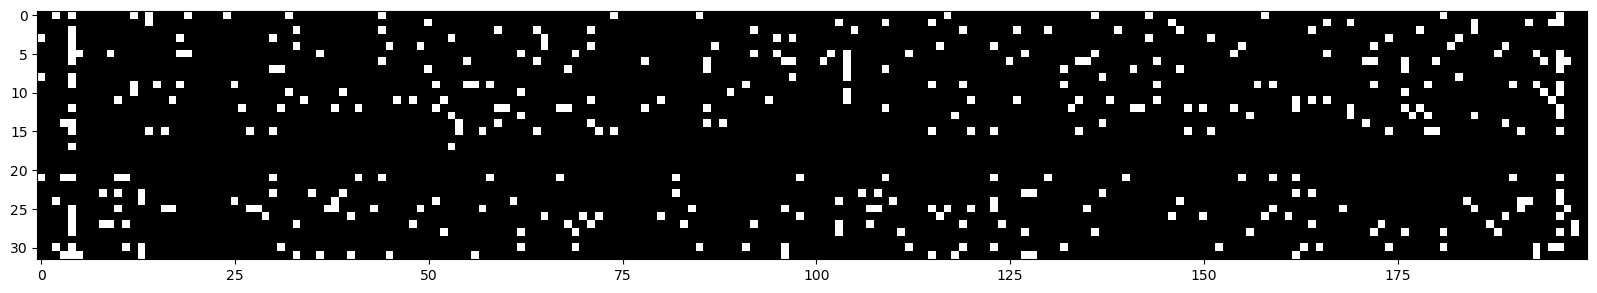

In [144]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

ddORae = [1 if any(e.abs() > 0.99 for e in n) else 0 for n in h]
ddORae

(array([477., 227., 159., 142., 139., 104.,  98.,  99., 100.,  84.,  74.,
         92., 117.,  85.,  83., 115.,  84., 130.,  97., 152., 118., 117.,
        131., 135., 159., 122., 135., 155., 140., 116.,  84., 105.,  62.,
         87., 113.,  99.,  88.,  75.,  51.,  74.,  82.,  79., 109.,  98.,
         93., 117., 164., 173., 212., 449.]),
 array([-9.99930799e-01, -9.59932543e-01, -9.19934287e-01, -8.79936031e-01,
        -8.39937775e-01, -7.99939519e-01, -7.59941263e-01, -7.19943007e-01,
        -6.79944751e-01, -6.39946495e-01, -5.99948239e-01, -5.59949983e-01,
        -5.19951727e-01, -4.79953471e-01, -4.39955215e-01, -3.99956959e-01,
        -3.59958704e-01, -3.19960448e-01, -2.79962192e-01, -2.39963936e-01,
        -1.99965680e-01, -1.59967424e-01, -1.19969168e-01, -7.99709117e-02,
        -3.99726558e-02,  2.56001949e-05,  4.00238562e-02,  8.00221121e-02,
         1.20020368e-01,  1.60018624e-01,  2.00016880e-01,  2.40015136e-01,
         2.80013392e-01,  3.20011648e-01,  3.60009

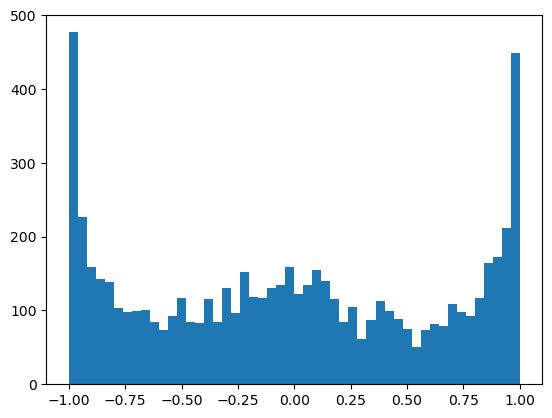

In [145]:
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   1.,   5.,  10.,   8.,  10.,  18.,  15.,  25.,  37.,  58.,
         62.,  67.,  92., 127., 138., 156., 194., 242., 278., 336., 423.,
        657., 758., 523., 427., 252., 267., 199., 221., 171., 133., 106.,
         88.,  64.,  56.,  44.,  33.,  19.,  29.,  12.,  14.,   5.,   7.,
          2.,   2.,   2.,   0.,   4.,   1.]),
 array([-5.13595152, -4.91706464, -4.69817776, -4.47929088, -4.260404  ,
        -4.04151711, -3.82263023, -3.60374335, -3.38485647, -3.16596959,
        -2.94708271, -2.72819583, -2.50930895, -2.29042207, -2.07153519,
        -1.85264831, -1.63376143, -1.41487454, -1.19598766, -0.97710078,
        -0.7582139 , -0.53932702, -0.32044014, -0.10155326,  0.11733362,
         0.3362205 ,  0.55510738,  0.77399426,  0.99288115,  1.21176803,
         1.43065491,  1.64954179,  1.86842867,  2.08731555,  2.30620243,
         2.52508931,  2.74397619,  2.96286307,  3.18174995,  3.40063684,
         3.61952372,  3.8384106 ,  4.05729748,  4.27618436,  4.49507124,
 

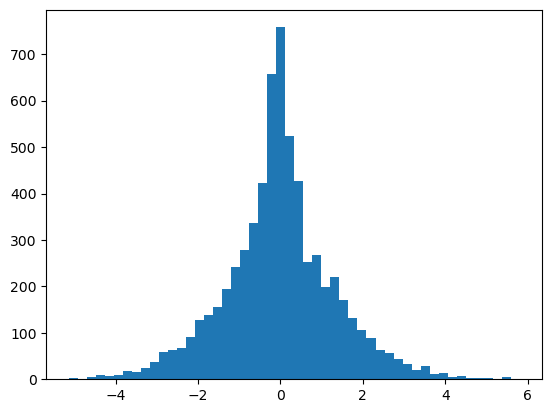

In [146]:
plt.hist(hpreact.view(-1).tolist(), 50)


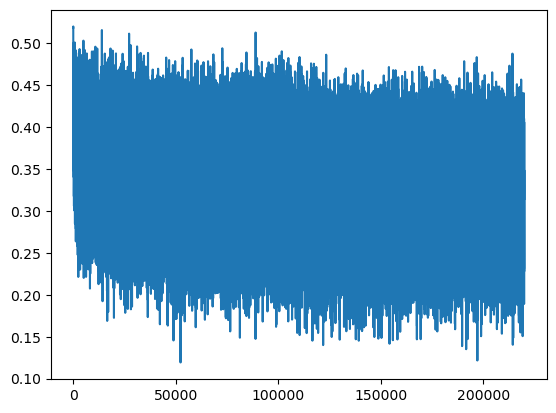

In [147]:
plt.plot([math.log10(l) for l in lossi])

In [157]:
def show_loss(X,Y):
    
    # forward pass
    emb = C[X]
    embcat = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2])
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()
 
print(f'train ds loss: {show_loss(Xtr, Ytr)}')
print(f'train ds loss: {show_loss(Xdev, Ydev)}')

train ds loss: 2.0381832122802734
train ds loss: 2.1113779544830322


In [158]:


for _ in range(20):

    out = []
    context = [0] * context_len
    while True: 
        
        # forward pass
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], emb.shape[1]*emb.shape[2])
        hpreact = embcat @ W1 + b1
        # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2    
        
        # soft-max beging
        counts = logits.exp() # equivalent to N
        probs = counts / counts.sum(1, keepdim=True)
        # soft-max end
                
        ix = torch.multinomial(probs[-1], num_samples=1).item()

        context = context[1:] + [ix]
        out.append(itos[ix])
        
        if ix == 0:
            break

    print(''.join(out))


idany.
della.
rosadia.
zanestyn.
grayan.
nika.
sara.
hakeelyn.
ana.
lebel.
savyn.
lexzen.
alen.
ciij.
kamaa.
bay.
deya.
chuntelilii.
arya.
rohaana.
